In [ ]:
import numpy as np

def sample_bimodal_gaussian(
    mu1: float, sigma1: float,
    mu2: float, sigma2: float,
    size: int = 1,
    weight: float = 0.5
) -> np.ndarray:
    """
    Generate random samples from a bimodal Gaussian (mixture of two Gaussians).

    Args:
        mu1 (float): Mean of the first Gaussian.
        sigma1 (float): Std dev of the first Gaussian.
        mu2 (float): Mean of the second Gaussian.
        sigma2 (float): Std dev of the second Gaussian.
        weight (float): Probability of sampling from the first Gaussian (0 to 1).
        size (int): Number of samples to generate.

    Returns:
        np.ndarray: Array of random samples from the bimodal distribution.
    """
    choices = np.random.rand(size) < weight
    samples = np.empty(size)
    samples[choices] = np.random.normal(mu1, sigma1, np.sum(choices))
    samples[~choices] = np.random.normal(mu2, sigma2, np.sum(~choices))
    samples[samples < 0] = 0
    return samples 

def sample_bimodal_gaussian2D(
    mu1: np.array, sigma1: np.array,
    mu2: np.array, sigma2: np.array,
    size: int = 1,
    weight: float = 0.5
) -> np.ndarray:
    """
    Generate random samples from a bimodal Gaussian (mixture of two Gaussians).

    Args:
        mu1 (float): Mean of the first Gaussian.
        sigma1 (float): Std dev of the first Gaussian.
        mu2 (float): Mean of the second Gaussian.
        sigma2 (float): Std dev of the second Gaussian.
        weight (float): Probability of sampling from the first Gaussian (0 to 1).
        size (int): Number of samples to generate.

    Returns:
        np.ndarray: Array of random samples from the bimodal distribution.
    """
    choices = np.random.rand(size) < weight
    samples0 = np.empty(size)
    samples0[choices] = np.random.normal(mu1[0], sigma1[0], np.sum(choices))
    samples0[~choices] = np.random.normal(mu2[0], sigma2[0], np.sum(~choices))
    samples0[samples0 < 0] = 0

    samples1 = np.empty(size)
    samples1[choices] = np.random.normal(mu1[1], sigma1[1], np.sum(choices))
    samples1[~choices] = np.random.normal(mu2[1], sigma2[1], np.sum(~choices))
    samples1[samples1 < 0] = 0
    return zip(samples0,samples1) 

# Throw Q A f1

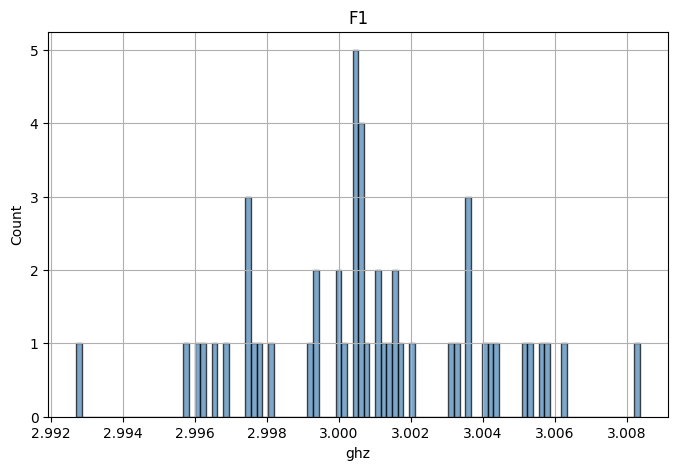

In [56]:
import  matplotlib.pyplot as plt

BIMODE = False
_f1 = 3.000e9
_lo = _f1 - 30e6
_hi = _f1 + 30e6
_s  = 3e6
_counts = 50 
if BIMODE:
    F_A_SAMPLE = sample_bimodal_gaussian(_lo,_s,_hi,_s,_counts)
else:
    F_A_SAMPLE = np.random.normal(_f1, _s, _counts)

# Drawn from PDF
plt.figure(figsize=(8, 5))
plt.hist(F_A_SAMPLE/1e9, bins=100, alpha=0.7, color='steelblue', edgecolor='black')
plt.xlabel("ghz")
plt.ylabel("Count")
plt.title("F1")
plt.grid(True)
plt.show()

## with ZZ coupling

In [ ]:

# Two-qubit simultaneous-Ramsey with ZZ coupling + T1/T2
# ---------------------------------------------------------------
import numpy as np, qutip as qt, matplotlib.pyplot as plt
from datetime import datetime

expA_list = []
expB_list = []
#T1_A_SAMPLE = [10e-6, 20e-6, 30e-6]
counter = 0 
test = 0 

for iQ_A in F_A_SAMPLE:
    if counter%10==0:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        print(f'loop: {counter} time: {timestamp}')
    counter+=1
        
    fA = iQ_A #3.000e9          # qubit bare freqs  (Hz)
    #fA = 3.000e9          # qubit bare freqs  (Hz)
    fB = 3.040e9
    detA = detB = 3e6                  # Ramsey detuning   (Hz)
    chi_MHz     = 0.01 #0.6                   # ZZ  (MHz)  (0 → no beating)

    T1_A = 110e-6 # iQ_A 
    #T1_A = iQ_A
    T1_B = 170e-6                       # T1  (s)
    T2_A = 170e-6
    T2_B = 190e-6                 # desired T2 (s)

    t_ns = np.linspace(0, 10000, 501)    # free-evolution delays (ns)


    wA,wB   = 2*np.pi*np.array([fA,fB])
    chi     = 2*np.pi*chi_MHz*1e6
    EdA,EdB = 0.01*wA, 0.01*wB          # Rabi → τπ/2≈8 ns
    pi2A,pi2B = np.pi/(2*EdA), np.pi/(2*EdB)
    tau_p   = float(max(pi2A,pi2B))

    I,sx,sz,sm = qt.qeye(2),qt.sigmax(),qt.sigmaz(),qt.destroy(2)
    sxA,sxB = qt.tensor(sx,I), qt.tensor(I,sx)
    szA,szB = qt.tensor(sz,I), qt.tensor(I,sz)
    smA,smB = qt.tensor(sm,I), qt.tensor(I,sm)
    nA,nB   = qt.tensor(qt.num(2),I),   qt.tensor(I,qt.num(2))

    # ─── Collapse operators for given T1 and T2 ─────────────────
    def collapse_ops(T1,T2,sm_op,sz_op):
        g1  = 1/T1
        gphi = max(0, 1/T2 - g1/2)      # 1/T2 = 1/(2T1)+1/Tphi
        return [np.sqrt(g1)*sm_op, np.sqrt(0.5*gphi)*sz_op]

    c_ops = ( collapse_ops(T1_A,T2_A,smA,szA) +
              collapse_ops(T1_B,T2_B,smB,szB) )

    # ─── Static Hamiltonian ───────────────────────────
    H0 = 0.5*wA*szA + 0.5*wB*szB + chi/4*szA*szB
    def gate_coeff(ω,amp,t0,t1):
        return lambda t,args=None: amp*np.cos(ω*t) if t0<=t<t1 else 0.0

    def H_sequence(delay_s):
        t1s,t1e = 0.0,        pi2A
        t2s,t2e = tau_p,      tau_p+pi2A
        return [H0,
                [sxA, gate_coeff(wA+2*np.pi*detA, EdA, t1s, t1e)],
                [sxB, gate_coeff(wB+2*np.pi*detB, EdB, t1s, pi2B)],
                [sxA, gate_coeff(wA+2*np.pi*detA, EdA, t2s+delay_s, t2e+delay_s)],
                [sxB, gate_coeff(wB+2*np.pi*detB, EdB, t2s+delay_s, pi2B+tau_p+delay_s)]], \
               2*tau_p + delay_s

    # ───  Ramsey point (single integration) ──────────────────────
    opts = qt.Options(nsteps=20000, store_final_state=True, atol=1e-7, rtol=1e-6)
    psi_g = qt.tensor(qt.basis(2,0), qt.basis(2,0))

    def ramsey(delay_ns):
        τ = delay_ns*1e-9
        H,t_tot = H_sequence(τ)
        tlist = np.linspace(0,t_tot,int(t_tot/2e-9)+1)  # 2-ns solver step
        st = qt.mesolve(H, psi_g, tlist, c_ops, e_ops=[], options=opts).states[-1]
        return qt.expect(nA,st), qt.expect(nB,st)

    expA,expB = np.array(qt.parallel_map(ramsey,t_ns,progress_bar=False)).T
    #expA,expB = np.array([ramsey(t) for t in t_ns]).T

    expA_list.append(expA)
    expB_list.append(expB)    

# write to file
# Create a timestamp string
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Create filename
filename = f"results_f1_10khz_t1a110_t2a170_{timestamp}_gphi.npz"

# Save the lists to a compressed npz file
np.savez(filename, expA_list=expA_list, expB_list=expB_list, F_A_SAMPLE=F_A_SAMPLE)

print(f"Saved results to {filename}")


loop: 0 time: 20250722_220116
loop: 10 time: 20250722_222238
loop: 20 time: 20250722_223927
loop: 30 time: 20250722_225414
loop: 40 time: 20250722_230805
loop: 50 time: 20250722_232214
loop: 60 time: 20250722_233721
loop: 70 time: 20250722_235421
loop: 80 time: 20250723_000851
loop: 90 time: 20250723_002453
loop: 100 time: 20250723_003927
loop: 110 time: 20250723_005259
loop: 120 time: 20250723_010822
loop: 130 time: 20250723_012755
loop: 140 time: 20250723_014242
Saved results to results_f1_10khz_t1a110_t2a170_20250723_020159.npz


In [59]:
def load_from_file(filename):
    # filename = "results_t1_10khz_YYYYMMDD_HHMMSS.npz"

    # Load the data
    data = np.load(filename)

    # Access arrays by their keys
    return data["expA_list"], data["expB_list"], data["F_A_SAMPLE"]

expA_list,expB_list,F_A_SAMPLE = load_from_file('results_f1_10khz_t1a110_t2a170_20250723_020159.npz')
len(expA_list)

# results_f1_10khz_20250721_141318
# results_f1_10khz_t1a110_t2a170_20250723_020159

150

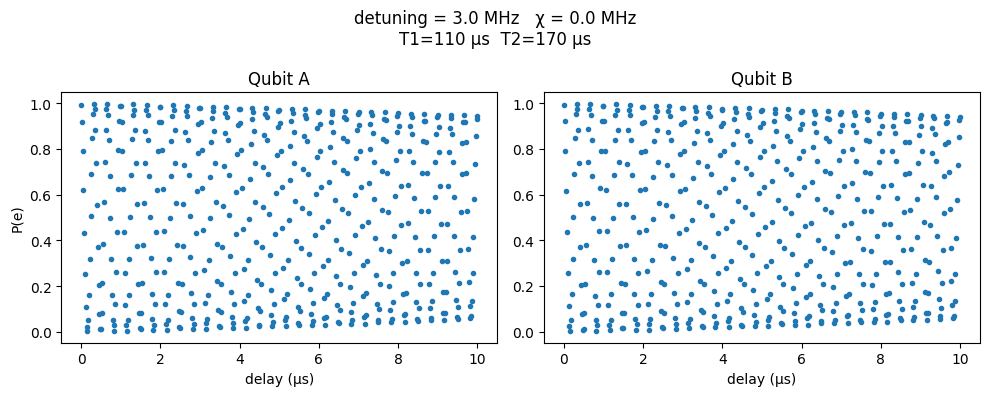

In [60]:
expA = expA_list[0]
expB = expB_list[0]
    
# ───  Plot ───────────────────────────────────────────────────
plt.figure(figsize=(10,4))
plt.subplot(121); plt.plot(t_ns/1000,expA,'.'); plt.title('Qubit A'); plt.xlabel('delay (µs)'); plt.ylabel('P(e)')
plt.subplot(122); plt.plot(t_ns/1000,expB,'.'); plt.title('Qubit B'); plt.xlabel('delay (µs)')
plt.suptitle(f'detuning = {detA/1e6:.1f} MHz   χ = {chi_MHz:.1f} MHz\nT1={T1_A*1e6:.0f} µs  T2={T2_A*1e6:.0f} µs')
plt.tight_layout(); plt.show()

## FIT with one amplitude
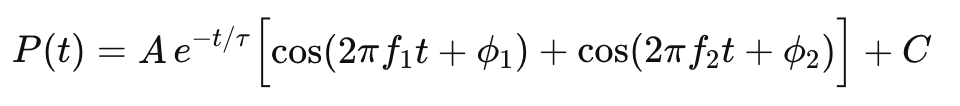

In [61]:
# ==================================================================
# Fit Ramsey beating to two decaying cosines  (requires SciPy ≥1.6)
# ==================================================================
import numpy as np, matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.fft import rfftfreq, rfft

# --- model --------------------------------------------------------
def double_cos(t_s, A, f1, f2, phi1, phi2, T2, C):
    env = A * np.exp(-t_s / T2)
    return env * (np.cos(2*np.pi*f1*t_s + phi1) +
                  np.cos(2*np.pi*f2*t_s + phi2)) + C

def single_cos(t_s, A, f1, f2, phi1, phi2, T2, C):
    env = A * np.exp(-t_s / T2)
    return env * np.cos(2*np.pi*f1*t_s + phi1) + C

# --- helper: crude initial guesses from FFT ----------------------
def guess_params(t_ns, y):
    t_s = t_ns*1e-9
    C0  = y.mean()
    A0  = 0.5*(y.max()-y.min())
    fs  = rfftfreq(len(t_s), t_s[1]-t_s[0])
    spec= np.abs(rfft(y-C0))
    peak_idx = spec.argsort()[-2:][::-1]   # two largest peaks
    f1, f2 = fs[peak_idx]
    return [A0, f1, f2, 0, 0, 5e-6, C0]

# --- report -------------------------------------------------------
def report(label, p):
    print(f"{label}:  f1 = {p[1]/1e6:.3f} MHz   f2 = {p[2]/1e6:.3f} MHz   "
          f"T2 = {p[5]*1e6:.1f} µs")
    
expA_t2 = []
expB_t2 = []
expA_p = []
expB_p = []

for expA, expB in zip(expA_list, expB_list):
    # --- fit both qubits ---------------------------------------------
    p0A = guess_params(t_ns, expA)
    p0B = guess_params(t_ns, expB)
    t_s = t_ns*1e-9

    bounds = ([0,0,0,-np.pi,-np.pi,0,0],
              [1,20e6,20e6,np.pi,np.pi,1e-3,1])

    #pA,_ = curve_fit(double_cos, t_s, expA, p0=p0A, bounds=bounds, maxfev=30000)
    #pB,_ = curve_fit(double_cos, t_s, expB, p0=p0B, bounds=bounds, maxfev=30000)

    pA,_ = curve_fit(single_cos, t_s, expA, p0=p0A,  maxfev=30000)
    pB,_ = curve_fit(single_cos, t_s, expB, p0=p0B,  maxfev=30000)

    report("Qubit-A", pA)
    report("Qubit-B", pB)

    expA_t2.append(pA[5])
    expB_t2.append(pB[5])

    expA_p.append(pA)
    expB_p.append(pB)


/tmp/ipykernel_751430/158231627.py:51: OptimizeWarning: Covariance of the parameters could not be estimated
  pA,_ = curve_fit(single_cos, t_s, expA, p0=p0A,  maxfev=30000)
/tmp/ipykernel_751430/158231627.py:52: OptimizeWarning: Covariance of the parameters could not be estimated
  pB,_ = curve_fit(single_cos, t_s, expB, p0=p0B,  maxfev=30000)


Qubit-A:  f1 = 2.999 MHz   f2 = 3.094 MHz   T2 = 85.5 µs
Qubit-B:  f1 = 2.999 MHz   f2 = 3.094 MHz   T2 = 83.5 µs
Qubit-A:  f1 = 3.000 MHz   f2 = 3.094 MHz   T2 = 2861117683.7 µs
Qubit-B:  f1 = 3.000 MHz   f2 = 3.094 MHz   T2 = 2385185492.1 µs
Qubit-A:  f1 = 2.999 MHz   f2 = 3.094 MHz   T2 = 53.1 µs
Qubit-B:  f1 = 2.999 MHz   f2 = 3.094 MHz   T2 = 50.9 µs
Qubit-A:  f1 = 3.000 MHz   f2 = 3.094 MHz   T2 = 1907503312.3 µs
Qubit-B:  f1 = 3.000 MHz   f2 = 3.094 MHz   T2 = 2426030591.3 µs
Qubit-A:  f1 = 2.999 MHz   f2 = 3.094 MHz   T2 = 84.4 µs
Qubit-B:  f1 = 2.999 MHz   f2 = 3.094 MHz   T2 = 82.3 µs
Qubit-A:  f1 = 2.999 MHz   f2 = 3.094 MHz   T2 = 94.2 µs
Qubit-B:  f1 = 2.999 MHz   f2 = 3.094 MHz   T2 = 92.4 µs
Qubit-A:  f1 = 2.999 MHz   f2 = 3.094 MHz   T2 = 50.2 µs
Qubit-B:  f1 = 2.999 MHz   f2 = 3.094 MHz   T2 = 47.9 µs
Qubit-A:  f1 = 2.999 MHz   f2 = 3.094 MHz   T2 = 53.7 µs
Qubit-B:  f1 = 2.999 MHz   f2 = 3.094 MHz   T2 = 51.5 µs
Qubit-A:  f1 = 2.999 MHz   f2 = 3.094 MHz   T2 = 85.5 µs

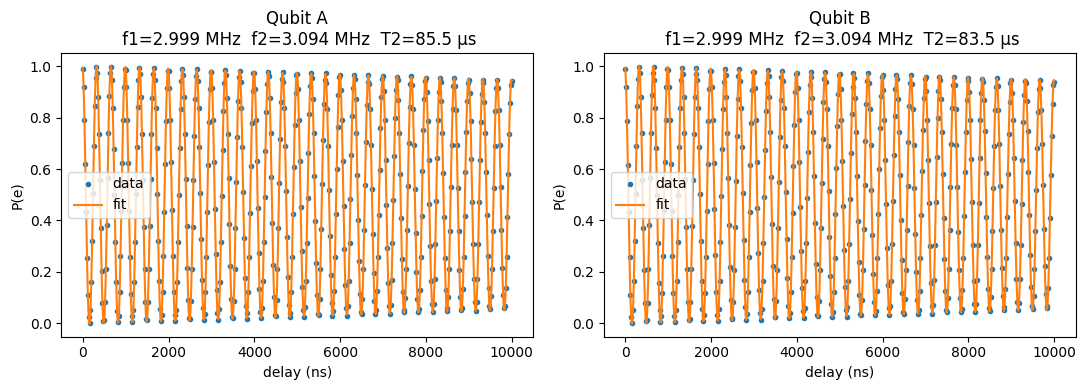

In [62]:
i=0
expA = expA_list[i]
expB = expB_list[i]
pA = expA_p[i]
pB = expB_p[i]

# --- plots ------------------------------------------------
tf_ns = np.linspace(t_ns[0], t_ns[-1], 1200)
fig, ax = plt.subplots(1,2, figsize=(11,4))
for k,(y,p,title) in enumerate(zip((expA,expB),(pA,pB),("Qubit A","Qubit B"))):
    ax[k].plot(t_ns, y, '.', label='data')
    ax[k].plot(tf_ns,
               single_cos(tf_ns*1e-9, *p), label='fit')
    ax[k].set_title(title+
        f"\n f1={p[1]/1e6:.3f} MHz  f2={p[2]/1e6:.3f} MHz  T2={p[5]*1e6:.1f} µs")
    ax[k].set_xlabel('delay (ns)'); ax[k].set_ylabel('P(e)')
    ax[k].legend()
plt.tight_layout(); plt.show()

## fit with two amplitudes 
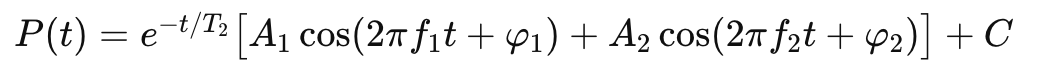

Qubit-A:  f1 = 2.995 MHz   f2 = 3.004 MHz   A1 = 0.29  A2 = 0.22   T2 = 1000.0 µs
Qubit-B:  f1 = 2.996 MHz   f2 = 3.006 MHz   A1 = 0.35  A2 = 0.16   T2 = 1000.0 µs


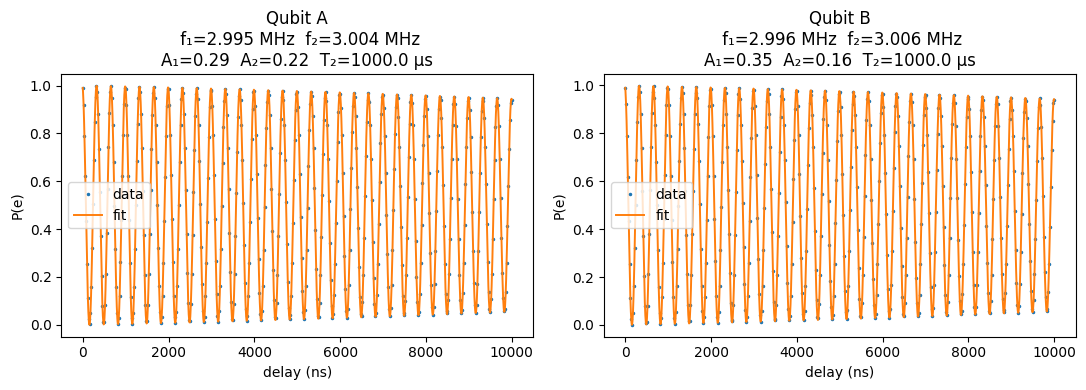

In [30]:
# ==================================================================
# Fit Ramsey beating with *independent* amplitudes for each branch
# Assumes t_ns, expA, expB are defined (from the simulation cell)
# ==================================================================
import numpy as np, matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.fft import rfftfreq, rfft

# ---------- model -------------------------------------------------
def two_amp_cos(t_s, A1, A2, f1, f2, phi1, phi2, T2, C):
    env = np.exp(-t_s / T2)
    return env * (A1*np.cos(2*np.pi*f1*t_s + phi1) +
                  A2*np.cos(2*np.pi*f2*t_s + phi2)) + C

# ---------- initial-guess helper (FFT) ---------------------------
def guess_params(t_ns, y):
    t_s = t_ns * 1e-9
    C0  = y.mean()
    
    y0  = y - C0
    A_guess = 0.5*(y.max()-y.min())
    fs   = rfftfreq(len(t_s), t_s[1]-t_s[0])
    spec = np.abs(rfft(y0))
    idx  = spec.argsort()[-2:][::-1]          # two largest peaks
    f1, f2 = fs[idx]
    return [A_guess, A_guess, f1, f2, 0.0, 0.0, 5e-6, C0]

# ---------- fit both qubits --------------------------------------
t_s = t_ns * 1e-9
p0A = guess_params(t_ns, expA)
p0B = guess_params(t_ns, expB)

bounds = ([0,0,      0,      0, -np.pi, -np.pi,        0, 0],   # lower
          [1,1,  20e6,  20e6,  np.pi,  np.pi,   1e-3, 1])       # upper

pA, _ = curve_fit(two_amp_cos, t_s, expA, p0=p0A,
                  bounds=bounds, maxfev=50000)
pB, _ = curve_fit(two_amp_cos, t_s, expB, p0=p0B,
                  bounds=bounds, maxfev=50000)

# ---------- report ----------------------------------------------
def report(label, p):
    print(f"{label}:  f1 = {p[2]/1e6:.3f} MHz   "
          f"f2 = {p[3]/1e6:.3f} MHz   "
          f"A1 = {p[0]:.2f}  A2 = {p[1]:.2f}   "
          f"T2 = {p[6]*1e6:.1f} µs")

report("Qubit-A", pA)
report("Qubit-B", pB)

# ---------- plots ---------------------------------------
tf_ns = np.linspace(t_ns[0], t_ns[-1], 1600)
fig, ax = plt.subplots(1,2, figsize=(11,4))
for k, (y, p, title) in enumerate(zip((expA, expB),
                                      (pA, pB),
                                      ("Qubit A", "Qubit B"))):
    ax[k].plot(t_ns, y, '.', ms=3, label='data')
    ax[k].plot(tf_ns,
               two_amp_cos(tf_ns*1e-9, *p), lw=1.4, label='fit')
    ax[k].set_title(title +
      (f"\n f₁={p[2]/1e6:.3f} MHz  f₂={p[3]/1e6:.3f} MHz\n"
       f"A₁={p[0]:.2f}  A₂={p[1]:.2f}  T₂={p[6]*1e6:.1f} µs"))
    ax[k].set_xlabel('delay (ns)'); ax[k].set_ylabel('P(e)')
    ax[k].legend()
plt.tight_layout(); plt.show()


# Sample Telegraphic Noise 

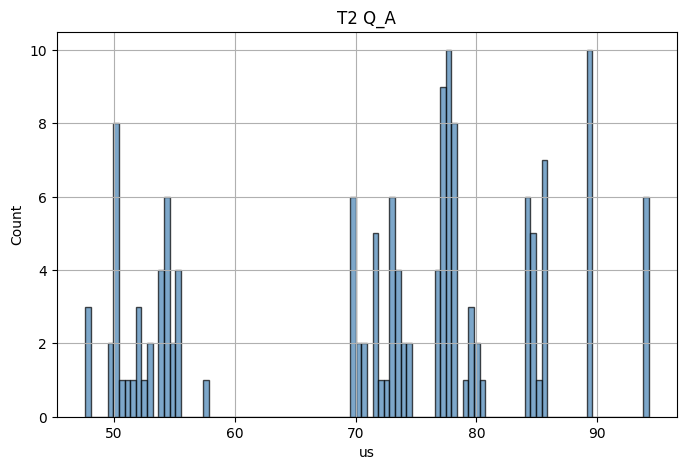

In [63]:
# Q A
plt.figure(figsize=(8, 5))
#plt.hist(np.array(expA_t2)*1e6, bins=100, alpha=0.7, color='steelblue', edgecolor='black')
plt.hist(np.array(expA_t2)[np.array(expA_t2)*1e6 < 200]*1e6, bins=100, alpha=0.7, color='steelblue', edgecolor='black')

plt.xlabel("us")
plt.ylabel("Count")
plt.title("T2 Q_A")
plt.grid(True)
plt.show()

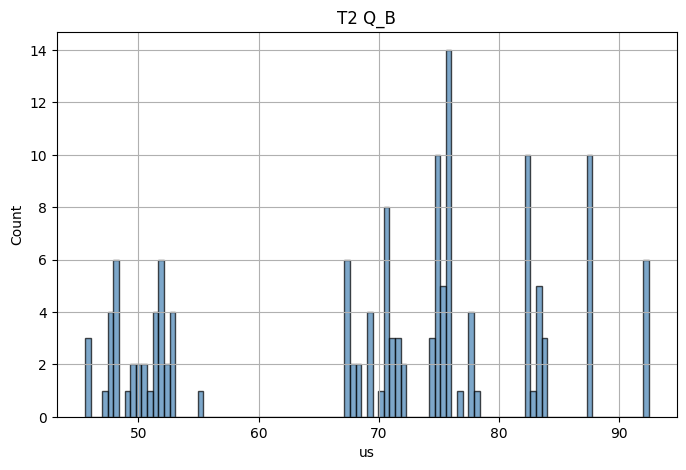

In [66]:
# Q B
expB_t2_f = [x for x in expB_t2 if x < 1000]
plt.figure(figsize=(8, 5))
plt.hist(np.array(expB_t2_f)*1e6, bins=100, alpha=0.7, color='steelblue', edgecolor='black')
plt.xlabel("us")
plt.ylabel("Count")
plt.title("T2 Q_B")
plt.grid(True)
plt.show()

In [14]:
expA = expA_list[0]
expB = expB_list[0]
# rabi osc pi pulse
i=np.argmax(expA)
print(i, expA[i])

399 1.0730541874119917


In [10]:
t_tot = 11
tlist = np.linspace(0,t_tot,20) 

In [48]:
def correlated_2d_normal(mean, cov, size=10000):
    """
    Generate and plot a correlated 2D normal distribution.

    Args:
        mean (list): Means for each dimension [mean_x, mean_y].
        cov (list of lists): Covariance matrix [[var_x, cov_xy], [cov_yx, var_y]].
        num_samples (int): Number of samples to generate.
        bins (int): Number of bins for the 2D histogram.
        cmap (str): Colormap for the heatmap.

    Returns:
        t1_samples (np.ndarray): Samples for the first variable.
        t2_samples (np.ndarray): Samples for the second variable.
    """
    samples = np.random.multivariate_normal(mean, cov, size)
    t1_samples = samples[:, 0]
    t2_samples = samples[:, 1]

    return t1_samples, t2_samples

In [49]:
def select_periodic(T_Hi, T_Lo, hr, size, time):
    """
    Select random items from T_Hi or T_Lo based on a periodic function with period hr.

    Args:
        T_Hi (np.ndarray): Array of high values.
        T_Lo (np.ndarray): Array of low values.
        hr (float): Period of the function (in same units as index).
        size (int): Number of items to select.
        phase (float): Optional phase offset (default 0).

    Returns:
        np.ndarray: Selected values, length=size.
    """
    tline = np.linspace(0,time,size)
    # Use a sine function to alternate selection
    selector = (np.sin(2 * np.pi * (tline / hr)) > 0)
    # Randomly select from T_Hi or T_Lo
    hi_choices = np.random.choice(T_Hi, size)
    lo_choices = np.random.choice(T_Lo, size)
    result = np.where(selector, hi_choices, lo_choices)
    return result, tline

In [50]:
mean1 = [50, 50]  # Means for T1 and T2
cov1 = [[250, 200],  # Covariance matrix: diagonal = variances, off-diagonal = correlation
       [200, 250]]
mean2 = [160, 190]  # Means for T1 and T2
cov2 = [[300, 200],  # Covariance matrix: diagonal = variances, off-diagonal = correlation
       [200, 300]]

T1_A_SAMPLE_LO, T2_A_SAMPLE_LO = correlated_2d_normal(mean1, cov1, size=50)
T1_A_SAMPLE_HI, T2_A_SAMPLE_HI = correlated_2d_normal(mean2, cov2, size=50)
lo = T2_A_SAMPLE_LO
hi = T2_A_SAMPLE_HI

res, tline = select_periodic(hi,lo,3,100,9)


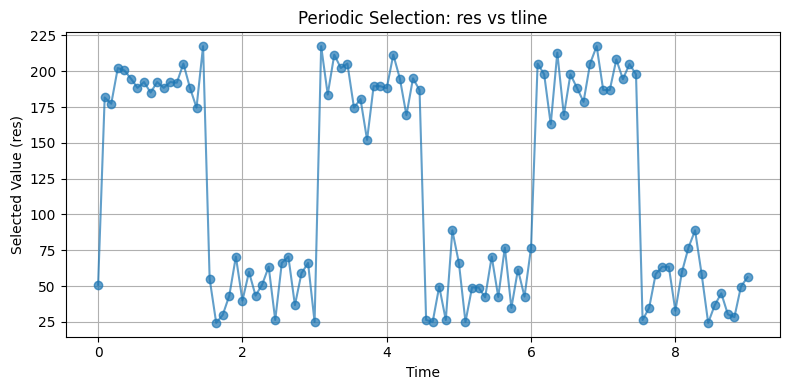

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(tline, res, 'o-', alpha=0.7)
plt.xlabel("Time")
plt.ylabel("Selected Value (res)")
plt.title("Periodic Selection: res vs tline")
plt.grid(True)
plt.tight_layout()
plt.show()

In [44]:
lo

array(0)

In [54]:
24*25/60

10.0